# 1. Introduction

Today I will explore the basketball player's performance dataset, and finish the required task by the author.

**Task Details:**
> I came up with this dataset in order to know that how long a player can play based on the previous summary stats.
> In this dataset there are 21 features describing the performance measures of each player or you can say the summary of each player.
> Your task is to predict the target variable.
> Target Variable:
> 1-Whether a player's career is equal to or greater than 5 years.
> 0-Career is shorter than 5 years
>Expected Submission
>You have to solve the task primarily using Notebooks
>Evaluation
>Use various Classification Algorithms to predict the target variable with higher accuracy score.


# 2. Import Libraries and load data

* 2.1 Import libraries needed

In [88]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from imblearn.combine import SMOTETomek

* 2.2 Load and Check Data

In [89]:
df = pd.read_csv('../input/performance-prediction/summary.csv')
df.head()

,Name,GamesPlayed,MinutesPlayed,PointsPerGame,FieldGoalsMade,FieldGoalsAttempt,FieldGoalPercent,3PointMade,3PointAttempt,3PointPercent,FreeThrowMade,FreeThrowAttempt,FreeThrowPercent,OffensiveRebounds,DefensiveRebounds,Rebounds,Assists,Steals,Blocks,Turnovers,Target
0,Brandon Ingram,36,27.4,7.4,2.6,7.6,34.7,0.5,2.1,25.0,1.6,2.3,69.9,0.7,3.4,4.1,1.9,0.4,0.4,1.3,0
1,Andrew Harrison,35,26.9,7.2,2.0,6.7,29.6,0.7,2.8,23.5,2.6,3.4,76.5,0.5,2.0,2.4,3.7,1.1,0.5,1.6,0
2,JaKarr Sampson,74,15.3,5.2,2.0,4.7,42.2,0.4,1.7,24.4,0.9,1.3,67.0,0.5,1.7,2.2,1.0,0.5,0.3,1.0,0
3,Malik Sealy,58,11.6,5.7,2.3,5.5,42.6,0.1,0.5,22.6,0.9,1.3,68.9,1.0,0.9,1.9,0.8,0.6,0.1,1.0,1
4,Matt Geiger,48,11.5,4.5,1.6,3.0,52.4,0.0,0.1,0.0,1.3,1.9,67.4,1.0,1.5,2.5,0.3,0.3,0.4,0.8,1


Check The dataset structure

In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1340 entries, 0 to 1339
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               1340 non-null   object 
 1   GamesPlayed        1340 non-null   int64  
 2   MinutesPlayed      1340 non-null   float64
 3   PointsPerGame      1340 non-null   float64
 4   FieldGoalsMade     1340 non-null   float64
 5   FieldGoalsAttempt  1340 non-null   float64
 6   FieldGoalPercent   1340 non-null   float64
 7   3PointMade         1340 non-null   float64
 8   3PointAttempt      1340 non-null   float64
 9   3PointPercent      1329 non-null   float64
 10  FreeThrowMade      1340 non-null   float64
 11  FreeThrowAttempt   1340 non-null   float64
 12  FreeThrowPercent   1340 non-null   float64
 13  OffensiveRebounds  1340 non-null   float64
 14  DefensiveRebounds  1340 non-null   float64
 15  Rebounds           1340 non-null   float64
 16  Assists            1340 

Check for missing values

In [91]:
df.isnull().sum()

Name                  0
GamesPlayed           0
MinutesPlayed         0
PointsPerGame         0
FieldGoalsMade        0
FieldGoalsAttempt     0
FieldGoalPercent      0
3PointMade            0
3PointAttempt         0
3PointPercent        11
FreeThrowMade         0
FreeThrowAttempt      0
FreeThrowPercent      0
OffensiveRebounds     0
DefensiveRebounds     0
Rebounds              0
Assists               0
Steals                0
Blocks                0
Turnovers             0
Target                0
dtype: int64

We have 11 missing values in 3PointPercent,

After checking the dataframe entries where there is missing data it appeared it's missing because it's a zero divide so we replace it with zero instead

In [92]:
df = df.fillna(0)

# EDA

Let's check the correlations of other features with a heat map

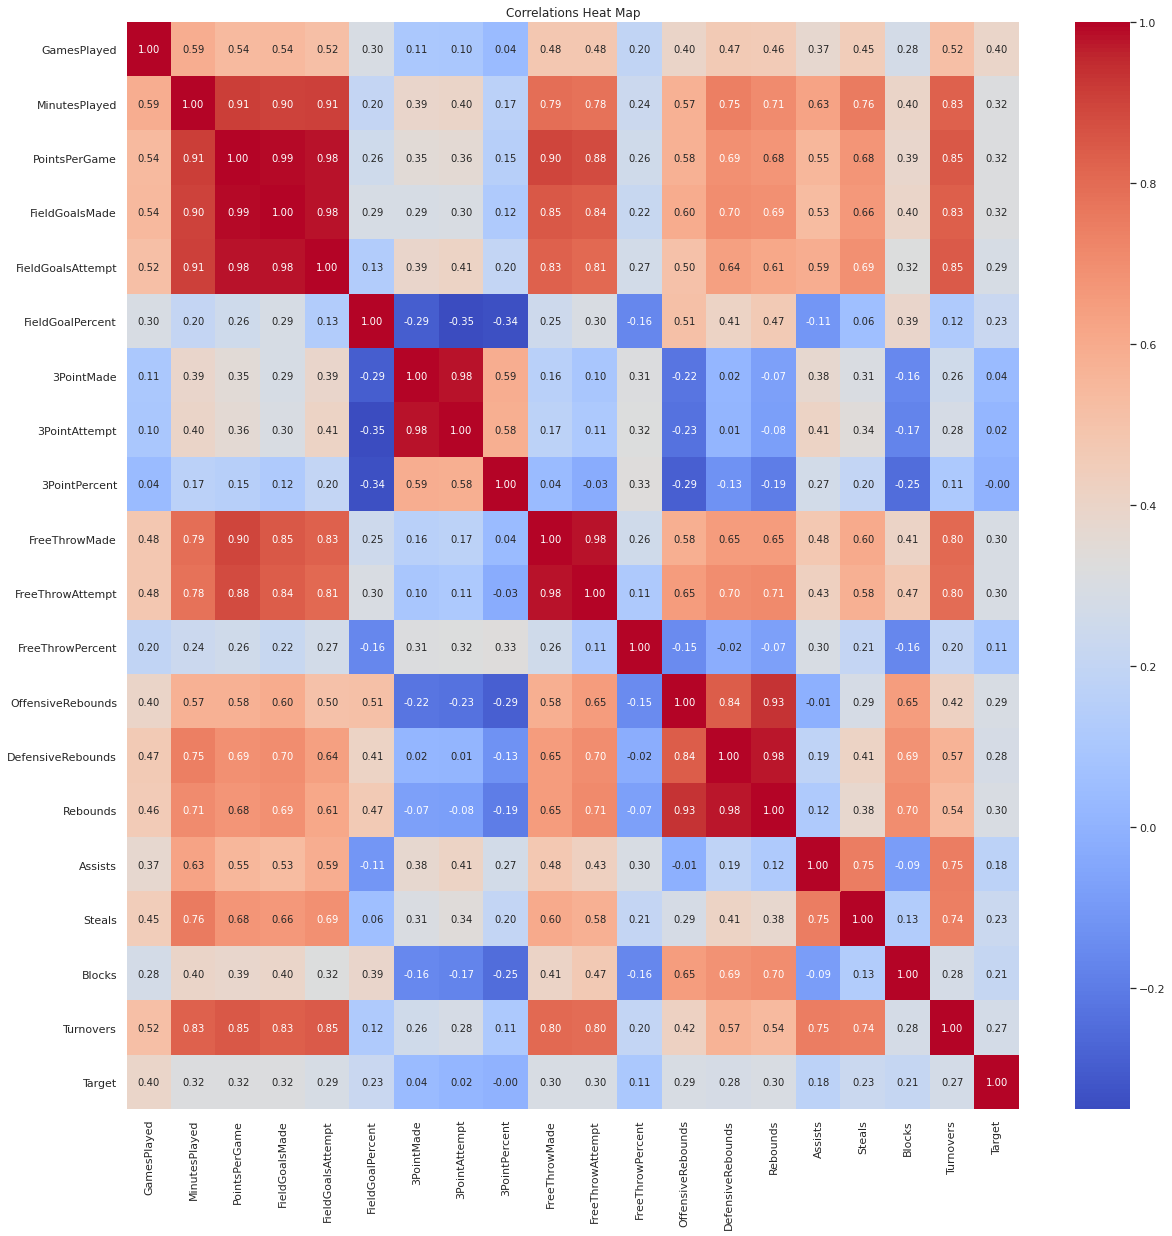

In [93]:
columns = df.columns.tolist()[1:]
plt.figure(figsize=(20,20))
sns.heatmap(df[columns].corr(),annot=True, fmt = ".2f", cmap = "coolwarm")
plt.title('Correlations Heat Map')
plt.show()

Let's Explore the GamesPlayed feature to see if it correlates 

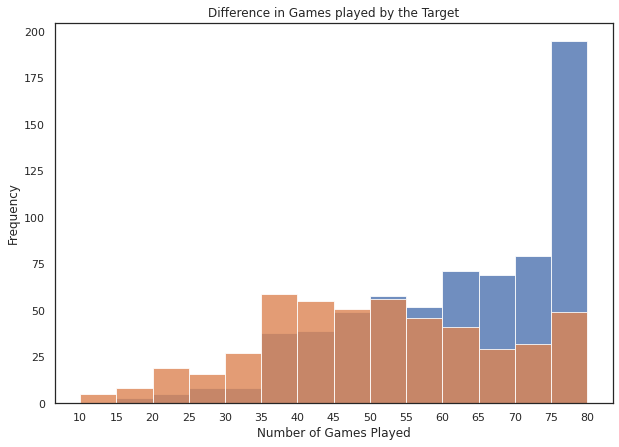

In [94]:
bins = np.arange(10,df.GamesPlayed.max(),5)
plt.figure(figsize=(10,7))
plt.hist(df[df.Target == 1].GamesPlayed,alpha=0.8,bins=bins)
plt.hist(df[df.Target == 0].GamesPlayed,alpha=0.8,bins=bins)
plt.title('Difference in Games played by the Target')
plt.xlabel('Number of Games Played')
plt.ylabel('Frequency')
plt.xticks(bins)
plt.show()

We Understand from this that on average players' career who played more than 50 games are more likely to be equal to or greater than 5 years.

#### It's obvious that more game will lead to more in every other feature else so let's introduce some new features

After some google searching we can intoduce 2 new features 
> Player Efficiency Rating : (FieldGoalsMade + Rebounds + Assists + Steals + Blocks + Turnovers)/ MinutesPlayed

> Participation : MinutesPlayed/GamedPlayed

In [95]:
df['efficiency'] = (df['FieldGoalsMade']+df['Rebounds']+df['Assists']+df['Steals']+df['Blocks']+df['Turnovers'])/df['MinutesPlayed']
df['Participation'] = df['MinutesPlayed']/df['GamesPlayed']

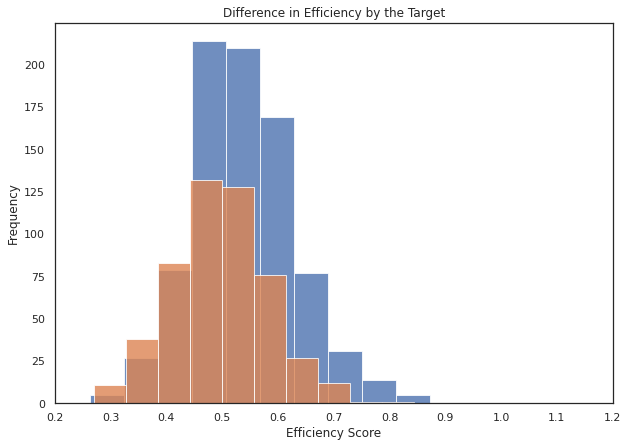

In [96]:
bins = np.arange(0.2,df.Participation.max(),0.1)
plt.figure(figsize=(10,7))
plt.hist(df[df.Target == 1]['efficiency'],alpha=0.8)
plt.hist(df[df.Target == 0]['efficiency'],alpha=0.8)
plt.title('Difference in Efficiency by the Target')
plt.xlabel('Efficiency Score')
plt.ylabel('Frequency')
plt.xticks(bins)
plt.show()

Ok so on everage higher efficiency score correlate with more experienced players

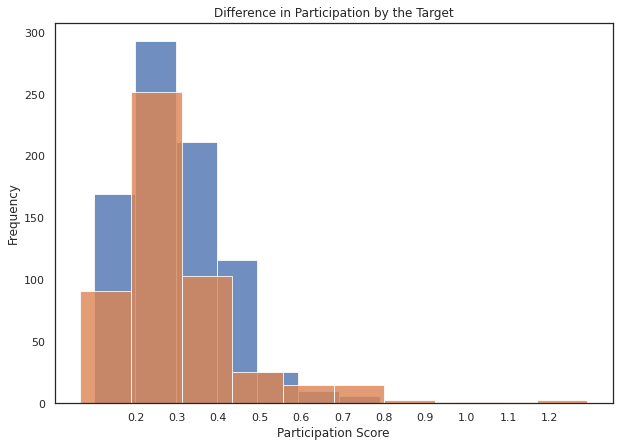

In [97]:
bins = np.arange(0.2,df.Participation.max(),0.1)
plt.figure(figsize=(10,7))
plt.hist(df[df.Target == 1]['Participation'],alpha=0.8)
plt.hist(df[df.Target == 0]['Participation'],alpha=0.8)
plt.title('Difference in Participation by the Target')
plt.xlabel('Participation Score')
plt.ylabel('Frequency')
plt.xticks(bins)
plt.show()

Not much difference between the two targets when it comes to participation score

Now let's make some predictions.



Will start with XGBoost

In [98]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler(feature_range=(0,1))

In [99]:
#Target
Y = df['Target'].values
#Inputs
X = df[['GamesPlayed', 'MinutesPlayed', 'PointsPerGame',
       'FieldGoalsMade', 'FieldGoalsAttempt', 'FieldGoalPercent', '3PointMade',
       '3PointAttempt', '3PointPercent', 'FreeThrowMade', 'FreeThrowAttempt',
       'FreeThrowPercent', 'OffensiveRebounds', 'DefensiveRebounds',
       'Rebounds', 'Assists', 'Steals', 'Blocks', 'Turnovers',
       'efficiency', ]].values
#Normalize our variables
X = mms.fit_transform(X)
#Split to training and testing
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
#Define the model
model = XGBClassifier(learning_rate = 0.1,n_estimators=200, max_depth=6)
#train the model
model.fit(X_train, y_train)
#Check training accuracy
trainingAccuracy =  metrics.accuracy_score(y_train,model.predict(X_train))
print("Training Accuracy: %.2f%%" % (trainingAccuracy * 100.0))
#Check testing accuracy
testingAccuracy =  metrics.accuracy_score(y_test, model.predict(X_test))
print("Testing Accuracy: %.2f%%" % (testingAccuracy * 100.0))

Training Accuracy: 98.60%
Testing Accuracy: 67.91%


We got 72.4% Accuracy from XGBoost

Let's try other classifiers

In [100]:
from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style='white', context='notebook', palette='deep')

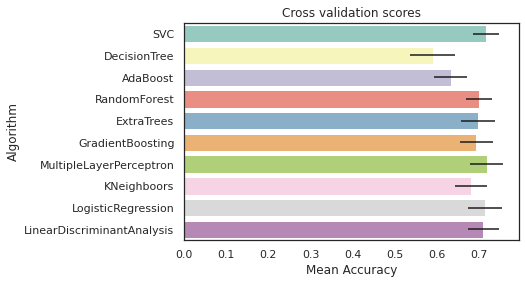

In [101]:
# Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=10)
# Modeling step Test differents algorithms 
random_state = 2
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = y_train, scoring = "accuracy", cv = kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

So XGBoost has the best Accuracy of 72.4%